In [197]:
import numpy as np
import matplotlib.pyplot as plt

In [198]:
data = np.genfromtxt('single_patient_data.txt', skip_header = 1)

In [199]:
time = data[:, 0]
conc = data[:, 1]
D0 = 400 * 1e6 #400 mg -> ng
bw = 84
F = 0.6
V = 20 * bw * 1000 #milliliters

In [200]:
#unknow ka and ke
k_a_in = 10
k_e_in = 50
A = np.array([k_a_in, k_e_in])
B = np.array([1.05 * A[0], A[1]])
C = np.array([A[0], 1.05 * A[1]])

In [201]:
from numpy import exp
def conc_func(t, k_a, k_e):
    c = (k_a * F * D0) / (V * (k_a - k_e)) * (exp(-k_e * t) - exp(-k_a * t))
    return c

In [202]:
def obj_fun(x):
    k_a = x[0]
    k_e = x[1]
    Conc = []
    mse = 0
    for i in range(0, len(time)):
        Conc.append(conc_func(time[i], k_a, k_e))
    Conc = np.array(Conc)
    for i in range(0, len(time)):
        mse += (Conc[i] - conc[i]) ** 2
    mse *= (1/(len(time)))
    # print(type(mse))
    return mse


In [203]:
simplex = {
    'vertices' : np.array([A, B, C]),
    'evals' : np.array([obj_fun(A), obj_fun(B), obj_fun(C)])
}


In [204]:
# def order_vertices(simplex):
#     simplex_vertices = simplex['vertices']
#     simplex_evals = simplex['evals']
#     idx = np.argsort(simplex_evals)

#     simplex_vertices = simplex_vertices[idx]
#     simplex_evals = simplex_vertices[idx]
#     #這三組是Ka, Ke
#     G = simplex_vertices[0]
#     A = simplex_vertices[1]
#     W = simplex_vertices[2]
#     #這三組是Ka, ke帶入進去跑出來的mse為多少 因此用eval的部分下去排序之後 回傳各個ka ke應該分配到Ｇ, A, 
#     G_eval = simplex_evals[0]
#     A_eval = simplex_evals[1]
#     W_eval = simplex_evals[2]
#     return {
#         'vertices' : np.array([G, A, W]),
#         'evals' : np.array([G_eval, A_eval, W_eval])
#     }

def order_vertices(simplex):
    vertices = np.array(simplex['vertices'])
    evals = np.array(simplex['evals'])

    idx = np.argsort(evals)

    vertices = vertices[idx]
    evals = evals[idx]   # ✅ 用 evals 排序 evals

    return {
        'vertices': vertices,
        'evals': evals
    }


In [205]:
def is_converge(simplex):
    tolerance = 1e-5
    if(np.linalg.norm(simplex['vertices'][0] - simplex['vertices'][2]) < tolerance):
        return True
    if (np.abs(simplex['evals'][0] - simplex['evals'][2]) < tolerance):
        return True
    return False

In [206]:
k_a_plot = []
k_e_plot = []


In [207]:
simplex = order_vertices(simplex)
max_iter = 10000
for i in range(0, max_iter):
    k_a_plot.append(simplex['vertices'][0][0])
    k_e_plot.append(simplex['vertices'][0][1])
    M = (simplex['vertices'][0] + simplex['vertices'][1]) / 2
    R = 2 * M - simplex['vertices'][2]
    R_eval = obj_fun(R)
    # print(simplex['evals'][0])
    if R_eval < simplex['evals'][0]: #Greater than best one
        T = 2 * R - M
        T_eval = obj_fun(T)
        if (T_eval < R_eval):
            simplex['vertices'][2] = T
            simplex['evals'][2] = T_eval
            #EXTENSION
        else:
            simplex['vertices'][2] = R
            simplex['evals'][2] = R_eval
            #REFLECTION
    else: #f(R) > f(G)
        A_eval = simplex['evals'][1]
        if(R_eval < A_eval):
            simplex['vertices'][2] = R
            simplex['evals'][2] = R_eval
            #REFLECTION2
        else:
            C_out = (M + R) / 2
            C_in = (M + simplex['vertices'][2]) / 2
            C_out_eval = obj_fun(C_out)
            C_in_eval = obj_fun(C_in)
            if(min(C_in_eval, C_out_eval) < A_eval):
                #Perform Contraction
                if (C_in_eval > C_out_eval):
                    C = C_out
                    C_eval = C_out_eval
                    simplex['vertices'][2] = simplex['vertices'][1]
                    simplex['vertices'][1] = simplex['vertices'][0]
                    simplex['vertices'][0] = C
                    simplex['evals'][2] = simplex['evals'][1]
                    simplex['evals'][1] = simplex['evals'][0]
                    simplex['evals'][0] = C_eval
                if (C_in_eval < C_out_eval):
                    C = C_in
                    C_eval = C_in_eval
                    simplex['vertices'][2] = simplex['vertices'][1]
                    simplex['vertices'][1] = simplex['vertices'][0]
                    simplex['vertices'][0] = C
                    simplex['evals'][2] = simplex['evals'][1]
                    simplex['evals'][1] = simplex['evals'][0]
                    simplex['evals'][0] = C_eval
            else:
                #Perfrom Shrink operation
                S1 = (simplex['vertices'][0] + simplex['vertices'][2]) / 2
                S2 = (simplex['vertices'][0] + simplex['vertices'][1]) / 2
                S1_eval = obj_fun(S1)
                S2_eval = obj_fun(S2)
                simplex['vertices'][1] = S2
                simplex['vertices'][2] = S1
                simplex['evals'][1] = S2_eval
                simplex['evals'][2] = S1_eval
    simplex = order_vertices(simplex)
    if(is_converge(simplex) == True):
        break

In [208]:
#Using Scipy to solve the same problem
from scipy.optimize import minimize
result = minimize(obj_fun, A, method='Nelder-Mead', options={'fatol': 1e-5})

print(result.x, 'in', )

[1.20184574 0.37643118] in


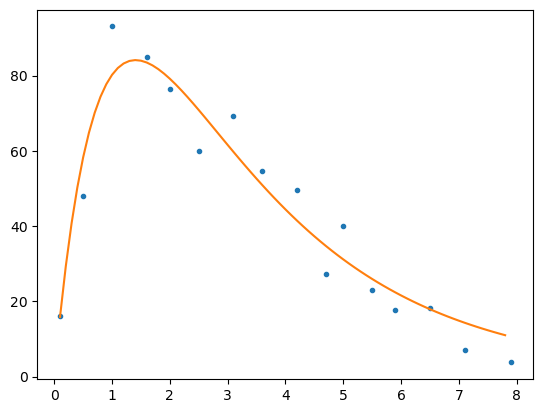

In [209]:
#Best is simplex['vertices'][0] = [Ka, ke]
time_plot = np.arange(min(time), max(time), 0.1)
plt.figure(1)
plt.plot(time, conc, '.')
plt.plot(time_plot, conc_func(time_plot, simplex['vertices'][0][0], simplex['vertices'][0][1]))
plt.show()

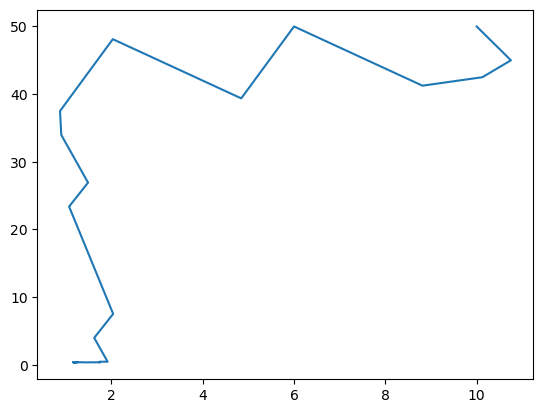

In [210]:
plt.figure(2)
plt.plot(k_a_plot, k_e_plot)
plt.show()